In [1]:
import multiprocessing as mp
import os
import shutil
import subprocess
import sys
from copy import deepcopy
from functools import partial
from io import StringIO
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
from torch import nn

import torchvision.transforms as T
import torchvision.transforms.functional as TF
import yaml
from IPython.display import display
from PIL import Image
from tqdm import tqdmls 

import pyiqa
from files.haled_adv.model import VanillaArch

sns.set_theme()

In [2]:
metrics_df = pd.read_csv('9-all-metrics.csv')
moses_df = pd.read_csv('moses.csv')

In [3]:
def split_filepath(filepath):
    x, y = filepath.split('/')[-2:]
    y = '.'.join(y.split('.')[:-1])
    return x, y

def parse_filename(file):
    fields = file.replace('.png', '').replace('h264v@', '').split('_')
    fields = [x.split('=') for x in fields]
    fields = {k: v for k, v in fields}
    fields = pd.DataFrame([fields])
    for col in fields.columns:
        try:
            fields[col] = pd.to_numeric(fields[col])
        except:
            pass
    out = fields.iloc[0].to_dict()
    return out

In [4]:
tmp = metrics_df.filename.apply(split_filepath)
metrics_df['sequence'], metrics_df['test_case'] = tmp.str[0], tmp.str[1]
del metrics_df['filename']

results_df = pd.merge(moses_df, metrics_df, on=['sequence', 'test_case'])

results_df = pd.concat([results_df, pd.json_normalize(results_df.test_case.apply(parse_filename))], axis=1)
df = results_df
df

,sequence,test_case,subjective_score,metric,dataset,metric_mode,is_sal,score,targetbbp100,preset
0,bantersnaps-2IAyiEitv-A-unsplash,h264v@targetbbp100=16_preset=p132,2.878964,psnr,full_res,FR,False,31.827345,16,p132
1,bantersnaps-2IAyiEitv-A-unsplash,h264v@targetbbp100=16_preset=p132,2.878964,psnr,resize_384,FR,False,33.638912,16,p132
2,bantersnaps-2IAyiEitv-A-unsplash,h264v@targetbbp100=16_preset=p132,2.878964,psnr,resize_384_512_or_512_384,FR,False,34.164207,16,p132
3,bantersnaps-2IAyiEitv-A-unsplash,h264v@targetbbp100=16_preset=p132,2.878964,psnr,resize_384_512_or_512_384_horizontal,FR,False,34.164207,16,p132
4,bantersnaps-2IAyiEitv-A-unsplash,h264v@targetbbp100=16_preset=p132,2.878964,ssim,full_res,FR,False,0.900716,16,p132
...,...,...,...,...,...,...,...,...,...,...
103675,sam-balye-g_j0P4dkkd0-unsplash,h264v@targetbbp100=16_preset=p132,5.521585,vanilla_small_adapter,resize_384_512_or_512_384_horizontal,NR,True,0.730496,16,p132
103676,sam-balye-g_j0P4dkkd0-unsplash,h264v@targetbbp100=16_preset=p132,5.521585,vanilla_small_adapter_pretrained,full_res,NR,True,0.602999,16,p132
103677,sam-balye-g_j0P4dkkd0-unsplash,h264v@targetbbp100=16_preset=p132,5.521585,vanilla_small_adapter_pretrained,resize_384,NR,True,0.715048,16,p132
103678,sam-balye-g_j0P4dkkd0-unsplash,h264v@targetbbp100=16_preset=p132,5.521585,vanilla_small_adapter_pretrained,resize_384_512_or_512_384,NR,True,0.721721,16,p132


In [5]:
metrics = list(df.metric.unique())
metrics

['psnr',
 'ssim',
 'ew_psnr',
 'ew_ssim',
 'ms_ssim',
 'topiq_fr',
 'lpips',
 'dists',
 'pieapp',
 'ahiq',
 'vif',
 'topiq_nr',
 'maniqa',
 'musiq',
 'clipiqa+',
 'hyperiqa',
 'dbcnn',
 'tres',
 'paq2piq',
 'brisque',
 'vanilla_baseline',
 'vanilla_gradcam',
 'vanilla_corners',
 'vanilla_vg_hard',
 'vanilla_vg_soft',
 'vanilla_salloss',
 'vanilla_big_adapter',
 'vanilla_multiple_concat',
 'vanilla_multiple_concat_pretrained',
 'vanilla_multiply',
 'vanilla_output_fuse',
 'vanilla_output_nofuse',
 'vanilla_ritm',
 'vanilla_ritm_pretrained',
 'vanilla_small_adapter',
 'vanilla_small_adapter_pretrained']

In [6]:
# metrics_order = [
#     "vanilla_baseline",
#     "vanilla_multiply",
#     "vanilla_output_fuse",
#     "vanilla_output_nofuse",
#     "vanilla_multiple_concat",
#     "vanilla_multiple_concat_pretrained",
#     "vanilla_small_adapter",
#     "vanilla_small_adapter_pretrained",
#     "vanilla_big_adapter",
#     "vanilla_ritm",
#     "vanilla_ritm_pretrained",
# ]

metrics_order = metrics

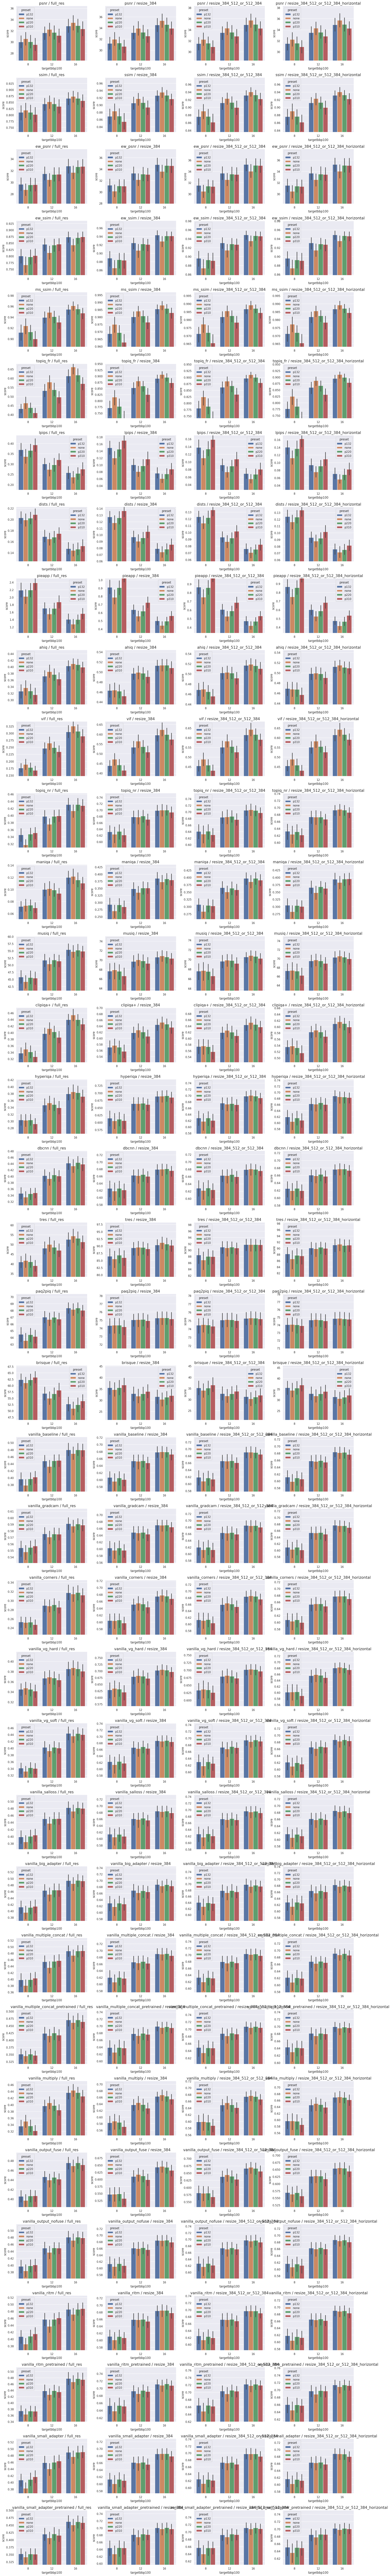

In [10]:
datasets = df.dataset.unique()
single_shape = (5, 4)
fig, axs = plt.subplots(
    len(metrics_order),
    len(datasets),
    figsize=(single_shape[0] * len(datasets), single_shape[1] * len(metrics_order)),
)

for i, metric in enumerate(metrics_order):
    subdf = df[(df.metric == metric)]
    for j, dataset in enumerate(df.dataset.unique()):
        ax = axs[i][j]
        subsubdf = subdf[(subdf.dataset == dataset)]
        sns.barplot(subsubdf, x="targetbbp100", y="score", hue="preset", ax=ax)
        ax.set_title(f"{metric} / {dataset}", fontsize=15)
        ax.set_ylim(
            subsubdf.score.mean() - subsubdf.score.std(),
            subsubdf.score.mean() + subsubdf.score.std(),
        )

plt.tight_layout()
plt.show()

In [9]:
def calc_corrs_for_group(group):
    return pd.Series(
        [
            scipy.stats.spearmanr(group.score, group.subjective_score)[0],
            scipy.stats.pearsonr(group.score, group.subjective_score)[0],
        ],
        index=["spearman", "pearson"],
    )

def calc_corrs(group):
    corrs = group.groupby(['sequence']).apply(calc_corrs_for_group)
    means = corrs.mean().apply(lambda x: f"{x:.3f}")
    std = corrs.std().apply(lambda x: f"{x:.2f}")
    return means + ' ± ' + std


corrs_df = df.groupby(['metric', 'dataset']).apply(calc_corrs).reset_index()

In [10]:
spearman_df = corrs_df.pivot(index='dataset', columns='metric', values='spearman')[metrics_order]
spearman_df

metric,psnr,ssim,ew_psnr,ew_ssim,ms_ssim,topiq_fr,lpips,dists,pieapp,ahiq,...,vanilla_big_adapter,vanilla_multiple_concat,vanilla_multiple_concat_pretrained,vanilla_multiply,vanilla_output_fuse,vanilla_output_nofuse,vanilla_ritm,vanilla_ritm_pretrained,vanilla_small_adapter,vanilla_small_adapter_pretrained
dataset,,,,,,,,,,,,,,,,,,,,,
full_res,0.822 ± 0.11,0.835 ± 0.10,0.875 ± 0.12,0.850 ± 0.15,0.807 ± 0.11,0.836 ± 0.10,-0.818 ± 0.11,-0.871 ± 0.09,-0.833 ± 0.10,0.789 ± 0.15,...,0.890 ± 0.08,0.866 ± 0.12,0.896 ± 0.07,0.859 ± 0.09,0.861 ± 0.13,0.881 ± 0.10,0.858 ± 0.13,0.897 ± 0.08,0.862 ± 0.12,0.896 ± 0.08
resize_384,0.820 ± 0.11,0.818 ± 0.10,0.890 ± 0.10,0.900 ± 0.11,0.796 ± 0.13,0.803 ± 0.12,-0.789 ± 0.14,-0.851 ± 0.11,-0.825 ± 0.10,0.834 ± 0.12,...,0.876 ± 0.13,0.910 ± 0.07,0.895 ± 0.09,0.879 ± 0.08,0.876 ± 0.08,0.908 ± 0.07,0.904 ± 0.07,0.885 ± 0.14,0.909 ± 0.07,0.871 ± 0.16
resize_384_512_or_512_384,0.818 ± 0.11,0.814 ± 0.11,0.891 ± 0.11,0.902 ± 0.11,0.796 ± 0.13,0.796 ± 0.14,-0.792 ± 0.14,-0.847 ± 0.11,-0.816 ± 0.10,0.834 ± 0.12,...,0.871 ± 0.16,0.894 ± 0.13,0.893 ± 0.13,0.879 ± 0.09,0.865 ± 0.10,0.888 ± 0.13,0.889 ± 0.12,0.872 ± 0.19,0.891 ± 0.12,0.880 ± 0.15
resize_384_512_or_512_384_horizontal,0.818 ± 0.11,0.814 ± 0.11,0.891 ± 0.11,0.902 ± 0.11,0.796 ± 0.13,0.784 ± 0.14,-0.790 ± 0.13,-0.860 ± 0.11,-0.825 ± 0.09,0.801 ± 0.17,...,0.842 ± 0.22,0.886 ± 0.13,0.877 ± 0.16,0.874 ± 0.10,0.872 ± 0.09,0.879 ± 0.17,0.871 ± 0.21,0.849 ± 0.22,0.883 ± 0.13,0.851 ± 0.19


In [11]:
pearson_df = corrs_df.pivot(index='dataset', columns='metric', values='pearson')[metrics_order]
pearson_df

metric,psnr,ssim,ew_psnr,ew_ssim,ms_ssim,topiq_fr,lpips,dists,pieapp,ahiq,...,vanilla_big_adapter,vanilla_multiple_concat,vanilla_multiple_concat_pretrained,vanilla_multiply,vanilla_output_fuse,vanilla_output_nofuse,vanilla_ritm,vanilla_ritm_pretrained,vanilla_small_adapter,vanilla_small_adapter_pretrained
dataset,,,,,,,,,,,,,,,,,,,,,
full_res,0.858 ± 0.10,0.880 ± 0.09,0.893 ± 0.12,0.867 ± 0.15,0.849 ± 0.10,0.848 ± 0.09,-0.854 ± 0.10,-0.904 ± 0.09,-0.869 ± 0.10,0.817 ± 0.13,...,0.899 ± 0.09,0.869 ± 0.14,0.916 ± 0.06,0.891 ± 0.07,0.875 ± 0.15,0.891 ± 0.10,0.861 ± 0.15,0.913 ± 0.08,0.857 ± 0.15,0.915 ± 0.08
resize_384,0.853 ± 0.11,0.856 ± 0.10,0.905 ± 0.11,0.918 ± 0.11,0.828 ± 0.11,0.830 ± 0.09,-0.824 ± 0.12,-0.876 ± 0.10,-0.849 ± 0.09,0.863 ± 0.10,...,0.916 ± 0.11,0.928 ± 0.06,0.916 ± 0.08,0.909 ± 0.07,0.907 ± 0.06,0.931 ± 0.06,0.924 ± 0.05,0.902 ± 0.12,0.924 ± 0.06,0.900 ± 0.11
resize_384_512_or_512_384,0.851 ± 0.11,0.855 ± 0.10,0.907 ± 0.11,0.921 ± 0.11,0.827 ± 0.11,0.824 ± 0.10,-0.823 ± 0.12,-0.876 ± 0.10,-0.846 ± 0.09,0.871 ± 0.09,...,0.903 ± 0.16,0.916 ± 0.12,0.907 ± 0.13,0.909 ± 0.08,0.899 ± 0.07,0.919 ± 0.10,0.913 ± 0.12,0.894 ± 0.18,0.913 ± 0.11,0.898 ± 0.14
resize_384_512_or_512_384_horizontal,0.851 ± 0.11,0.855 ± 0.10,0.907 ± 0.11,0.921 ± 0.11,0.827 ± 0.11,0.819 ± 0.10,-0.822 ± 0.12,-0.886 ± 0.10,-0.848 ± 0.09,0.842 ± 0.14,...,0.873 ± 0.22,0.913 ± 0.12,0.896 ± 0.17,0.907 ± 0.08,0.900 ± 0.08,0.910 ± 0.13,0.899 ± 0.19,0.885 ± 0.20,0.911 ± 0.12,0.885 ± 0.18


In [12]:
tmp = df.groupby(['metric', 'dataset', 'sequence'], as_index=False).apply(calc_corrs_for_group)
tmp

,metric,dataset,sequence,spearman,pearson
0,ahiq,full_res,aaron-greenwood-x9zy_1oHjqw-unsplash,0.944056,0.952332
1,ahiq,full_res,abhas-mishra-BD3qGeorAFY-unsplash,0.755245,0.714932
2,ahiq,full_res,abhay-singh-GGO53CCHM_Q-unsplash,0.846154,0.877655
3,ahiq,full_res,adrian-moise-0iRqoHHxjQk-unsplash,0.895105,0.913763
4,ahiq,full_res,alireza-zarafshani-lmZf8EVSmWM-unsplash,0.797203,0.801879
...,...,...,...,...,...
8635,vif,resize_384_512_or_512_384_horizontal,vijeshwar-datt-EaBYKGnfwdw-unsplash,0.881119,0.875522
8636,vif,resize_384_512_or_512_384_horizontal,youhana-nassif-YBpSX76CQaE-unsplash,0.944056,0.934904
8637,vif,resize_384_512_or_512_384_horizontal,yousef-salhamoud-MN1kPDS3si8-unsplash,0.678322,0.684865
8638,vif,resize_384_512_or_512_384_horizontal,zach-vessels-4i6OFPlJOFg-unsplash,0.503497,0.558328


In [24]:
tmp2 = tmp.copy()
tmp2['spearman'] = tmp2['spearman'].abs()
tmp2['pearson'] = tmp2['pearson'].abs()
tmp2 = tmp2[tmp2.dataset == 'full_res']
del tmp2['dataset']
tmp2

,metric,sequence,spearman,pearson
0,ahiq,aaron-greenwood-x9zy_1oHjqw-unsplash,0.944056,0.952332
1,ahiq,abhas-mishra-BD3qGeorAFY-unsplash,0.755245,0.714932
2,ahiq,abhay-singh-GGO53CCHM_Q-unsplash,0.846154,0.877655
3,ahiq,adrian-moise-0iRqoHHxjQk-unsplash,0.895105,0.913763
4,ahiq,alireza-zarafshani-lmZf8EVSmWM-unsplash,0.797203,0.801879
...,...,...,...,...
8455,vif,vijeshwar-datt-EaBYKGnfwdw-unsplash,0.944056,0.900049
8456,vif,youhana-nassif-YBpSX76CQaE-unsplash,0.965035,0.890406
8457,vif,yousef-salhamoud-MN1kPDS3si8-unsplash,0.720280,0.747415
8458,vif,zach-vessels-4i6OFPlJOFg-unsplash,0.608392,0.656926


In [50]:
metainfo = df[['metric', 'metric_mode', 'is_sal']].groupby(['metric', 'metric_mode', 'is_sal']).count()
metainfo_enriched = pd.merge(metainfo.reset_index(), tmp2.groupby(['metric'], as_index=False).agg(spearman_mean=('spearman', 'mean')), on='metric')
metainfo_enriched = metainfo_enriched.sort_values('spearman_mean')
metainfo_enriched.head()

,metric,metric_mode,is_sal,spearman_mean
9,maniqa,NR,False,0.752448
18,tres,NR,False,0.764685
7,hyperiqa,NR,False,0.784033
0,ahiq,FR,False,0.789394
10,ms_ssim,FR,False,0.806876


In [51]:
metainfo_enriched.loc[metainfo_enriched[metainfo_enriched.metric.isin(['vanilla_gradcam', 'vanilla_salloss'])].index, 'is_sal'] = True

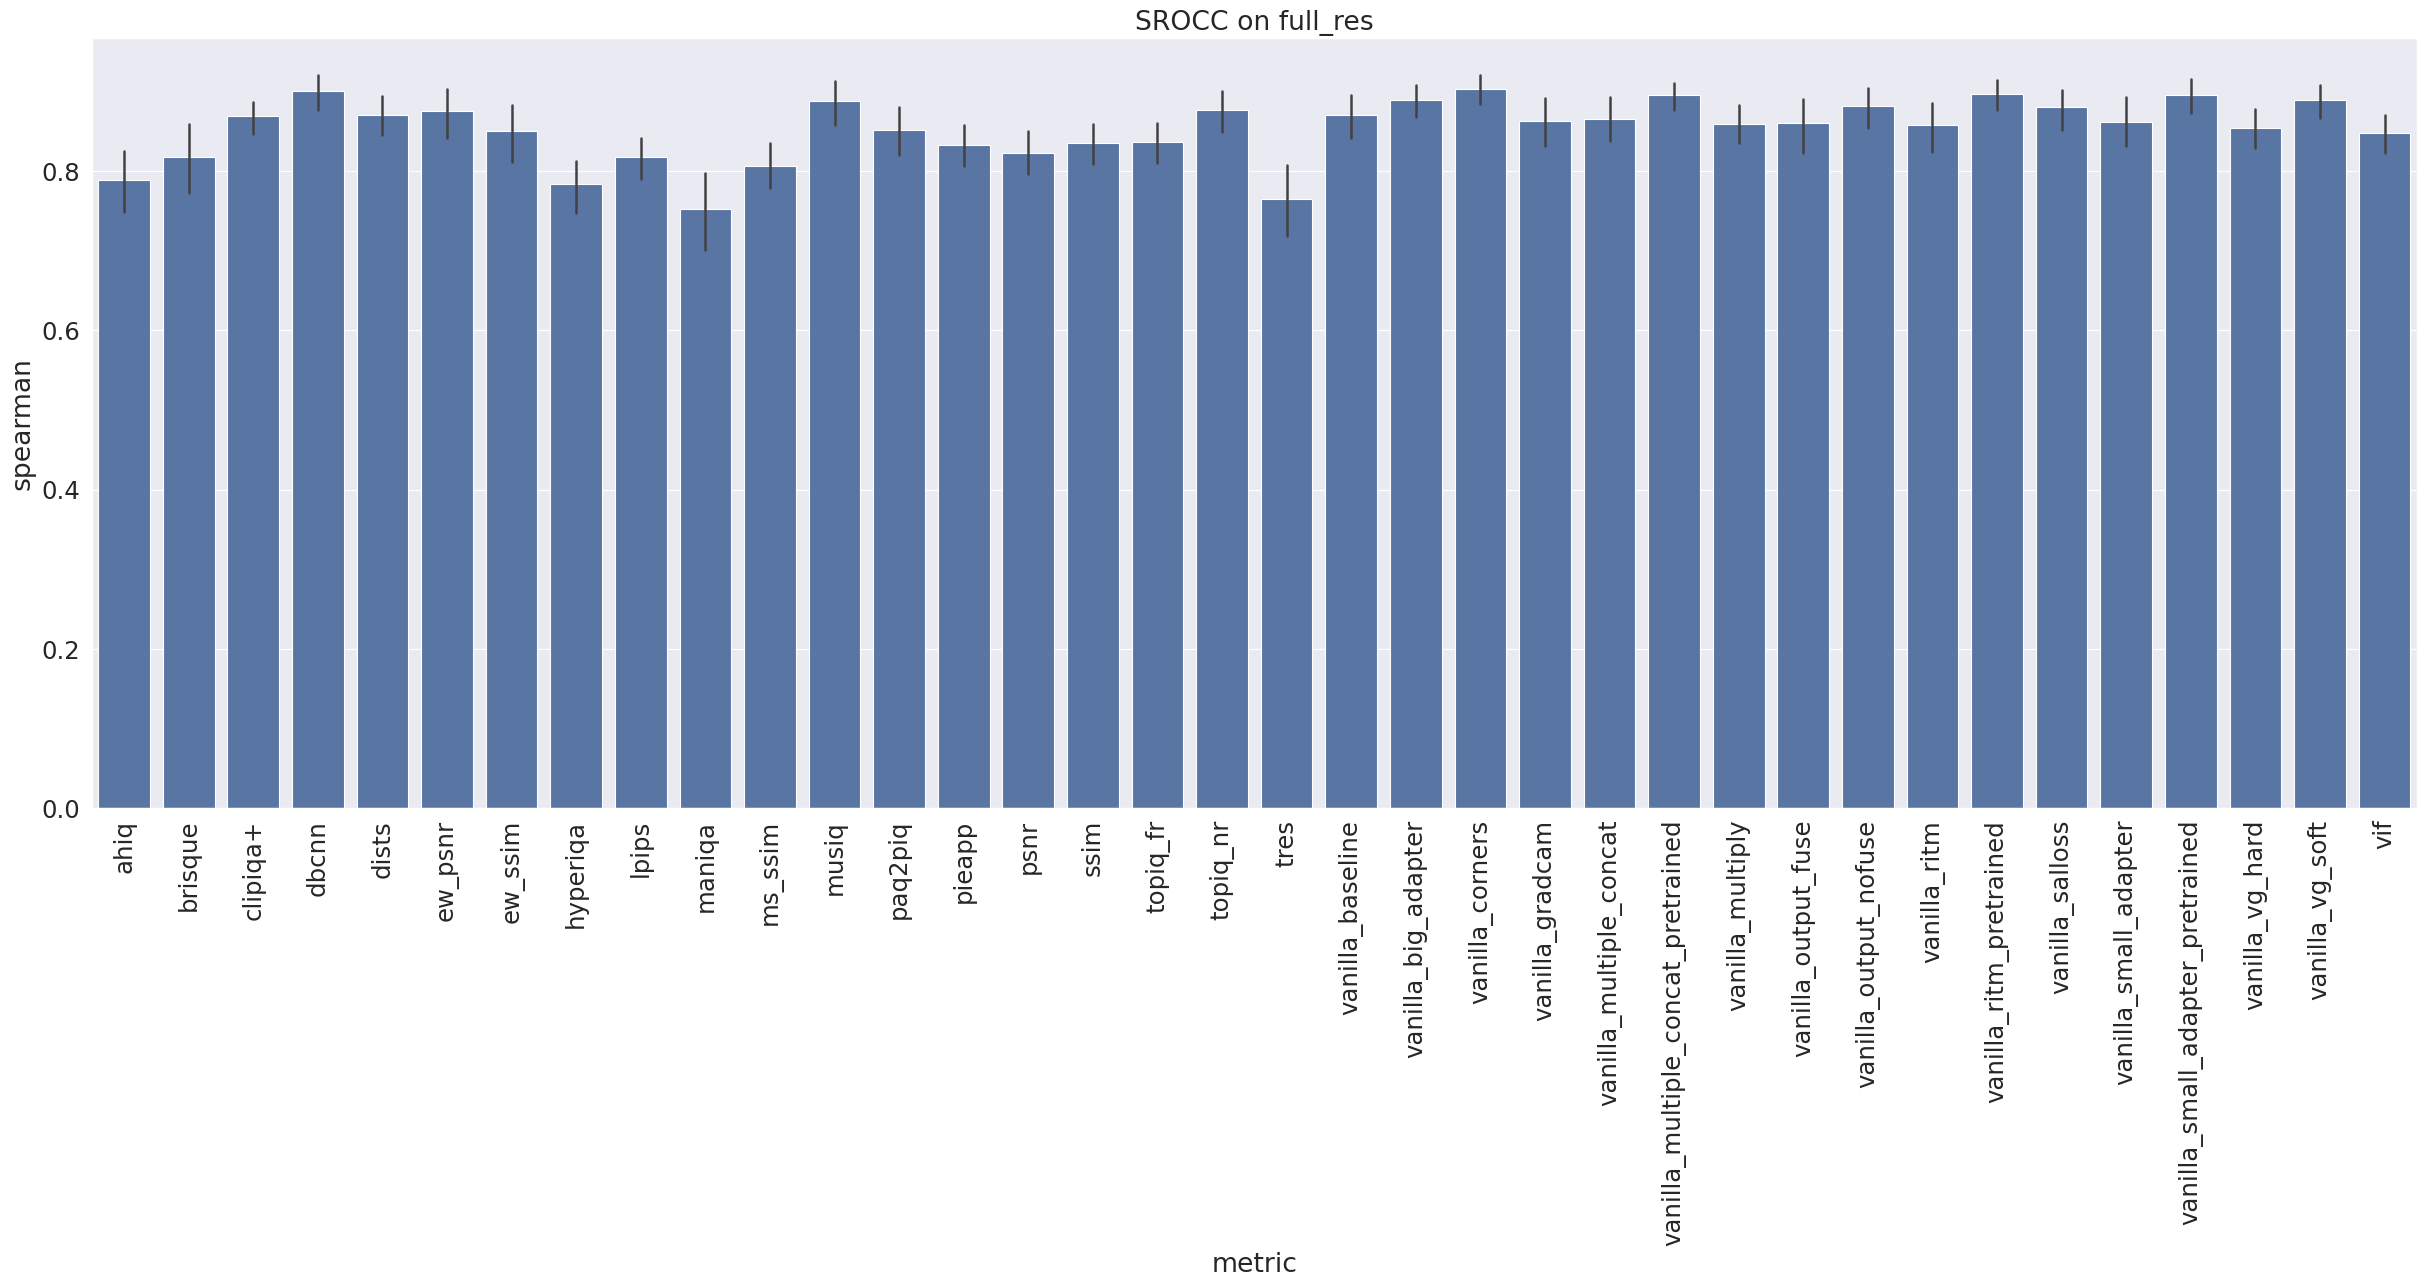

In [63]:
sns.set_context("paper", font_scale=2)      
plt.figure(figsize=(30, 10))
plt.title('SROCC on full_res')                                            
sns.barplot(tmp2, x='metric', y='spearman') #, order=metainfo_enriched.metric)
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_2953613/796128489.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(tmp2, ax=ax, x='metric', y='spearman', order=metainfo_enriched.metric, palette=cols)


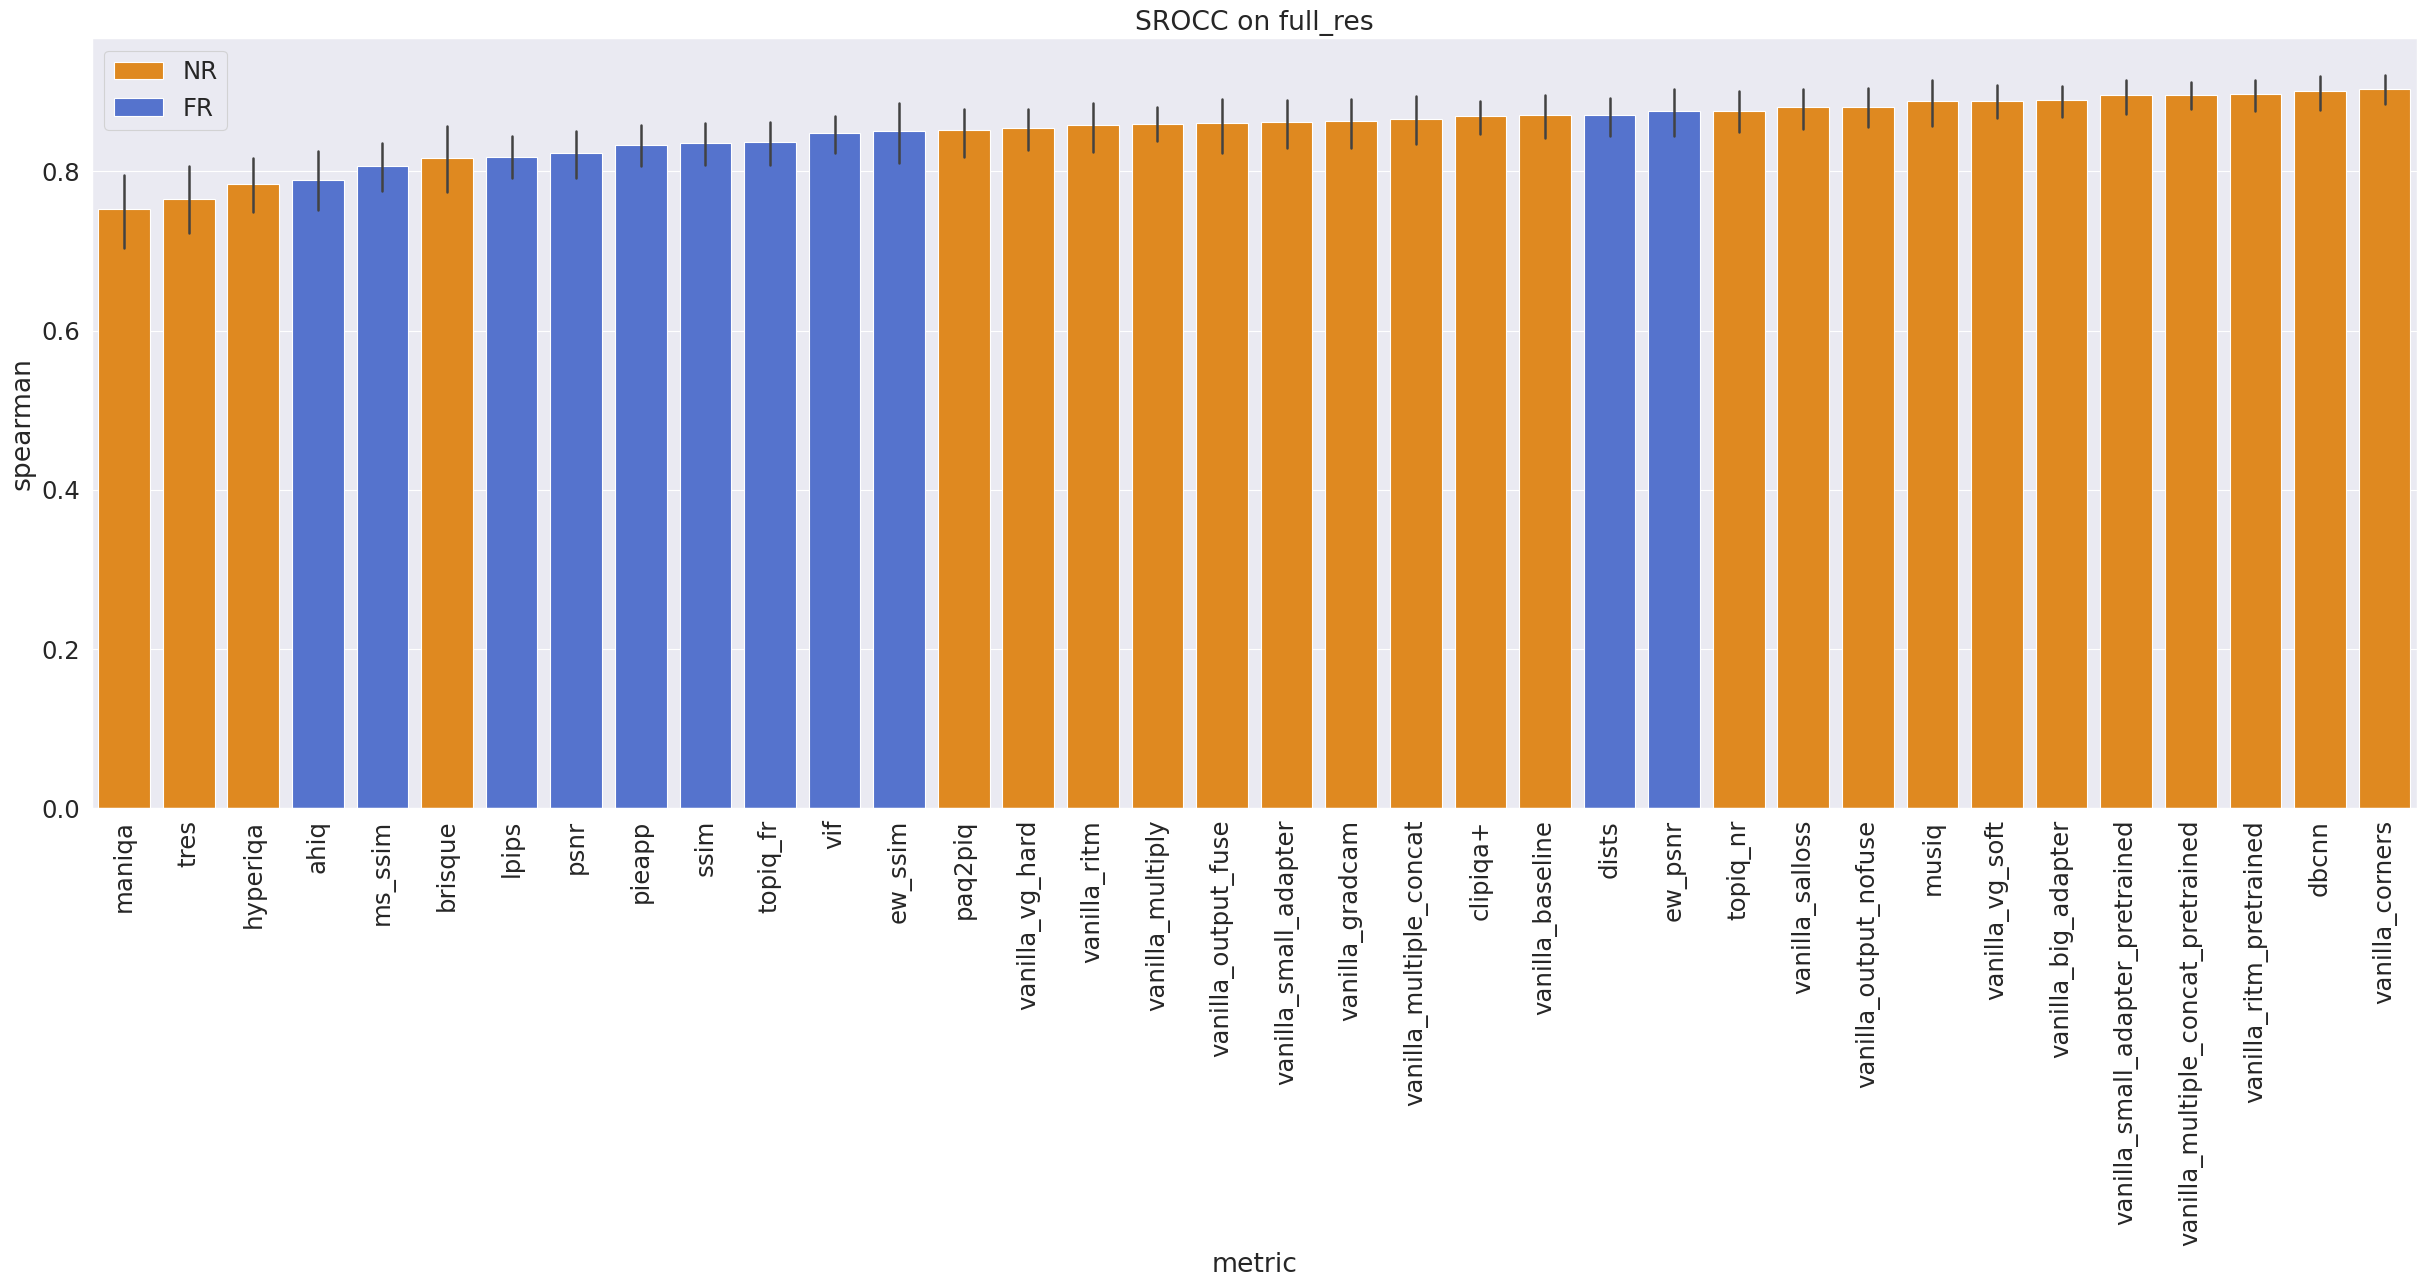

In [55]:
cols = ['royalblue' if not x.metric_mode == 'NR' else 'darkorange' for _, x in metainfo_enriched.iterrows()]

sns.set_context("paper", font_scale=2)      
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.title('SROCC on full_res')                                            
sns.barplot(tmp2, ax=ax, x='metric', y='spearman', order=metainfo_enriched.metric, palette=cols)
plt.xticks(rotation=90)
plt.legend([ax.containers[0], ax.containers[3]], ['NR', 'FR'])
plt.show()

/tmp/ipykernel_2953613/2012335163.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(tmp2[~tmp2.metric.str.contains('vanilla')], ax=ax, x='metric', y='spearman', order=[x for x in metainfo_enriched.metric if not 'vanilla' in x], palette=cols)


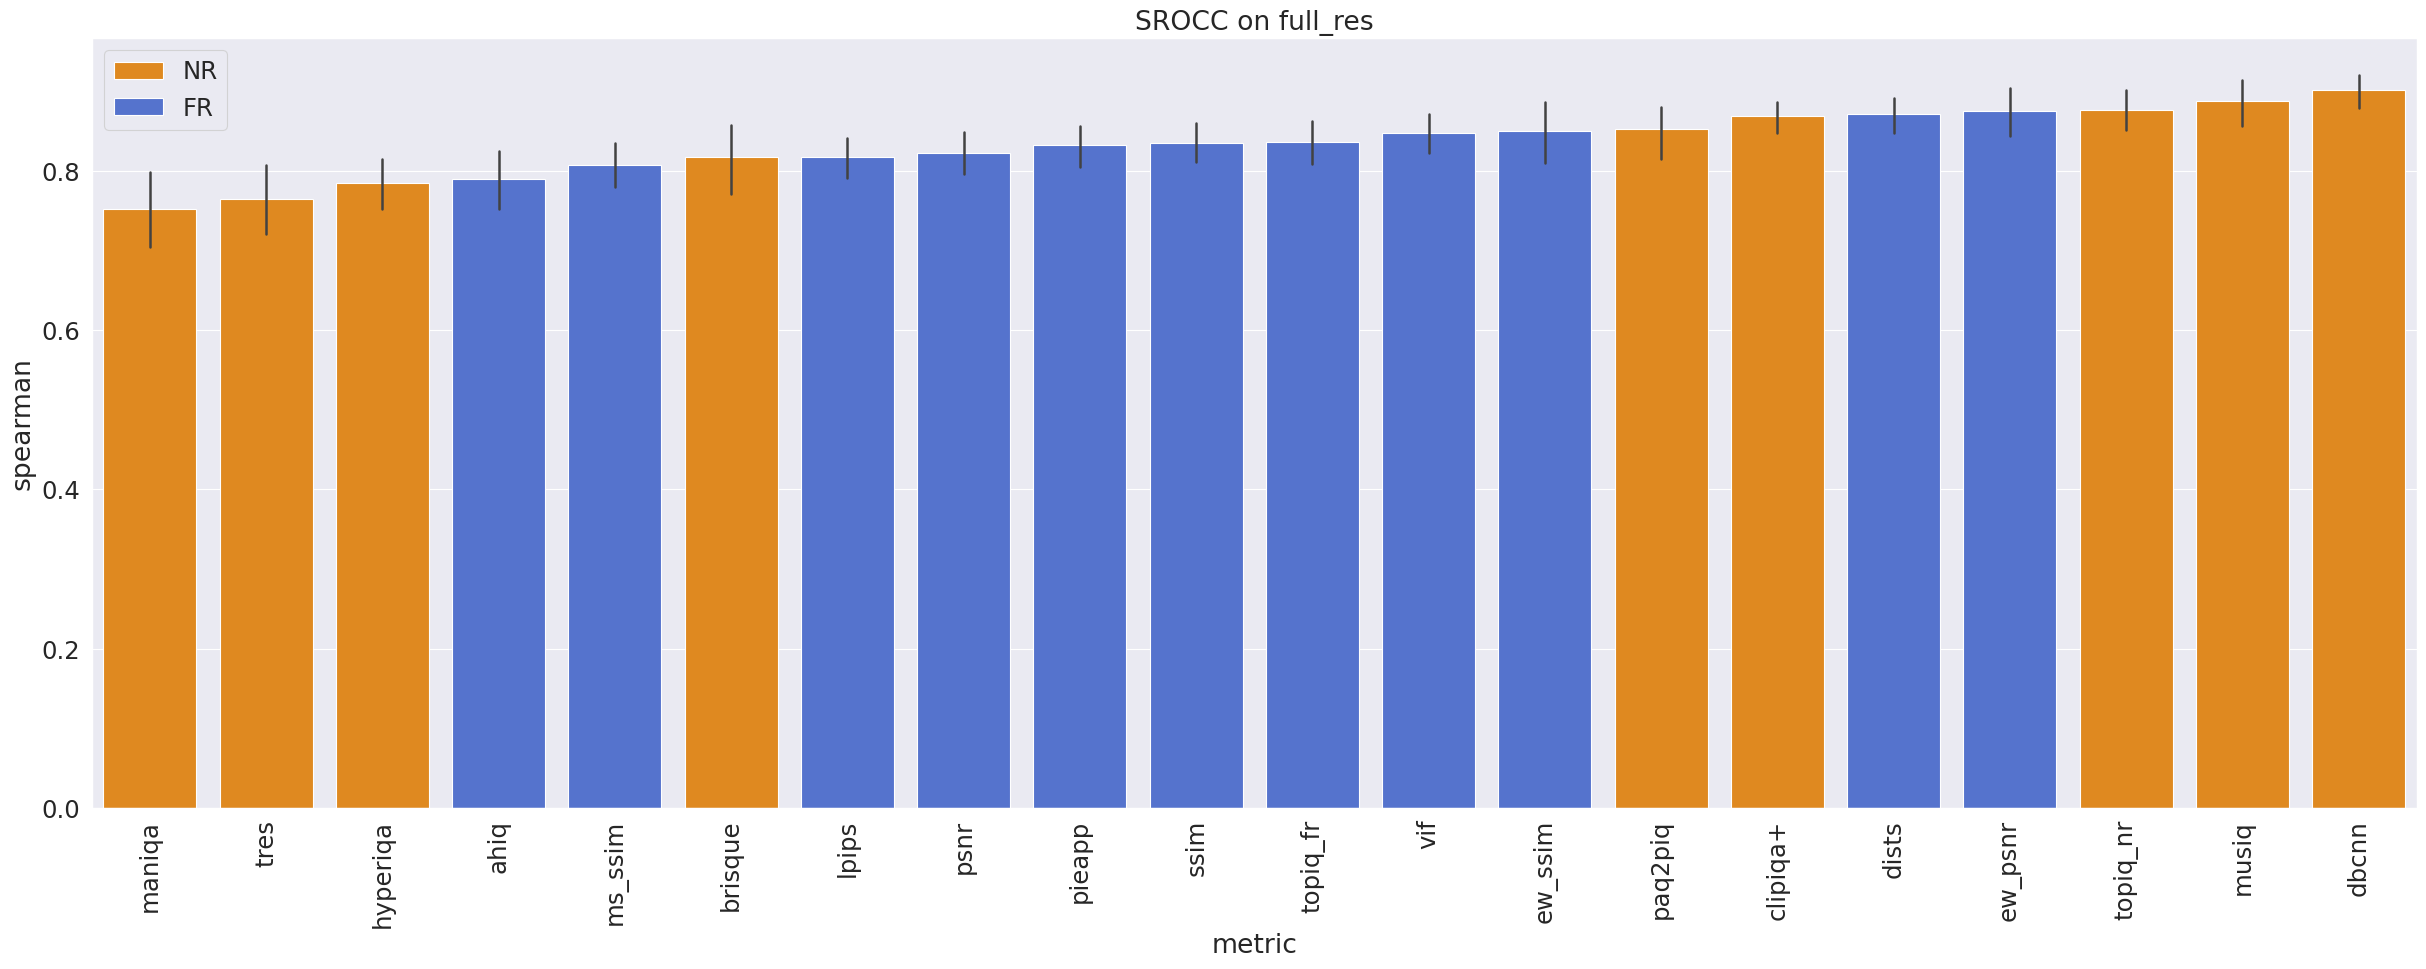

In [61]:
cols = ['royalblue' if not x.metric_mode == 'NR' else 'darkorange' for _, x in metainfo_enriched.iterrows() if 'vanilla' not in x.metric]

sns.set_context("paper", font_scale=2)      
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.title('SROCC on full_res')                                            
sns.barplot(tmp2[~tmp2.metric.str.contains('vanilla')], ax=ax, x='metric', y='spearman', order=[x for x in metainfo_enriched.metric if not 'vanilla' in x], palette=cols)
plt.xticks(rotation=90)
plt.legend([ax.containers[0], ax.containers[3]], ['NR', 'FR'])
plt.show()

/tmp/ipykernel_2953613/1270959214.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(tmp2, ax=ax, x='metric', y='spearman', order=metainfo_enriched.metric, palette=cols)


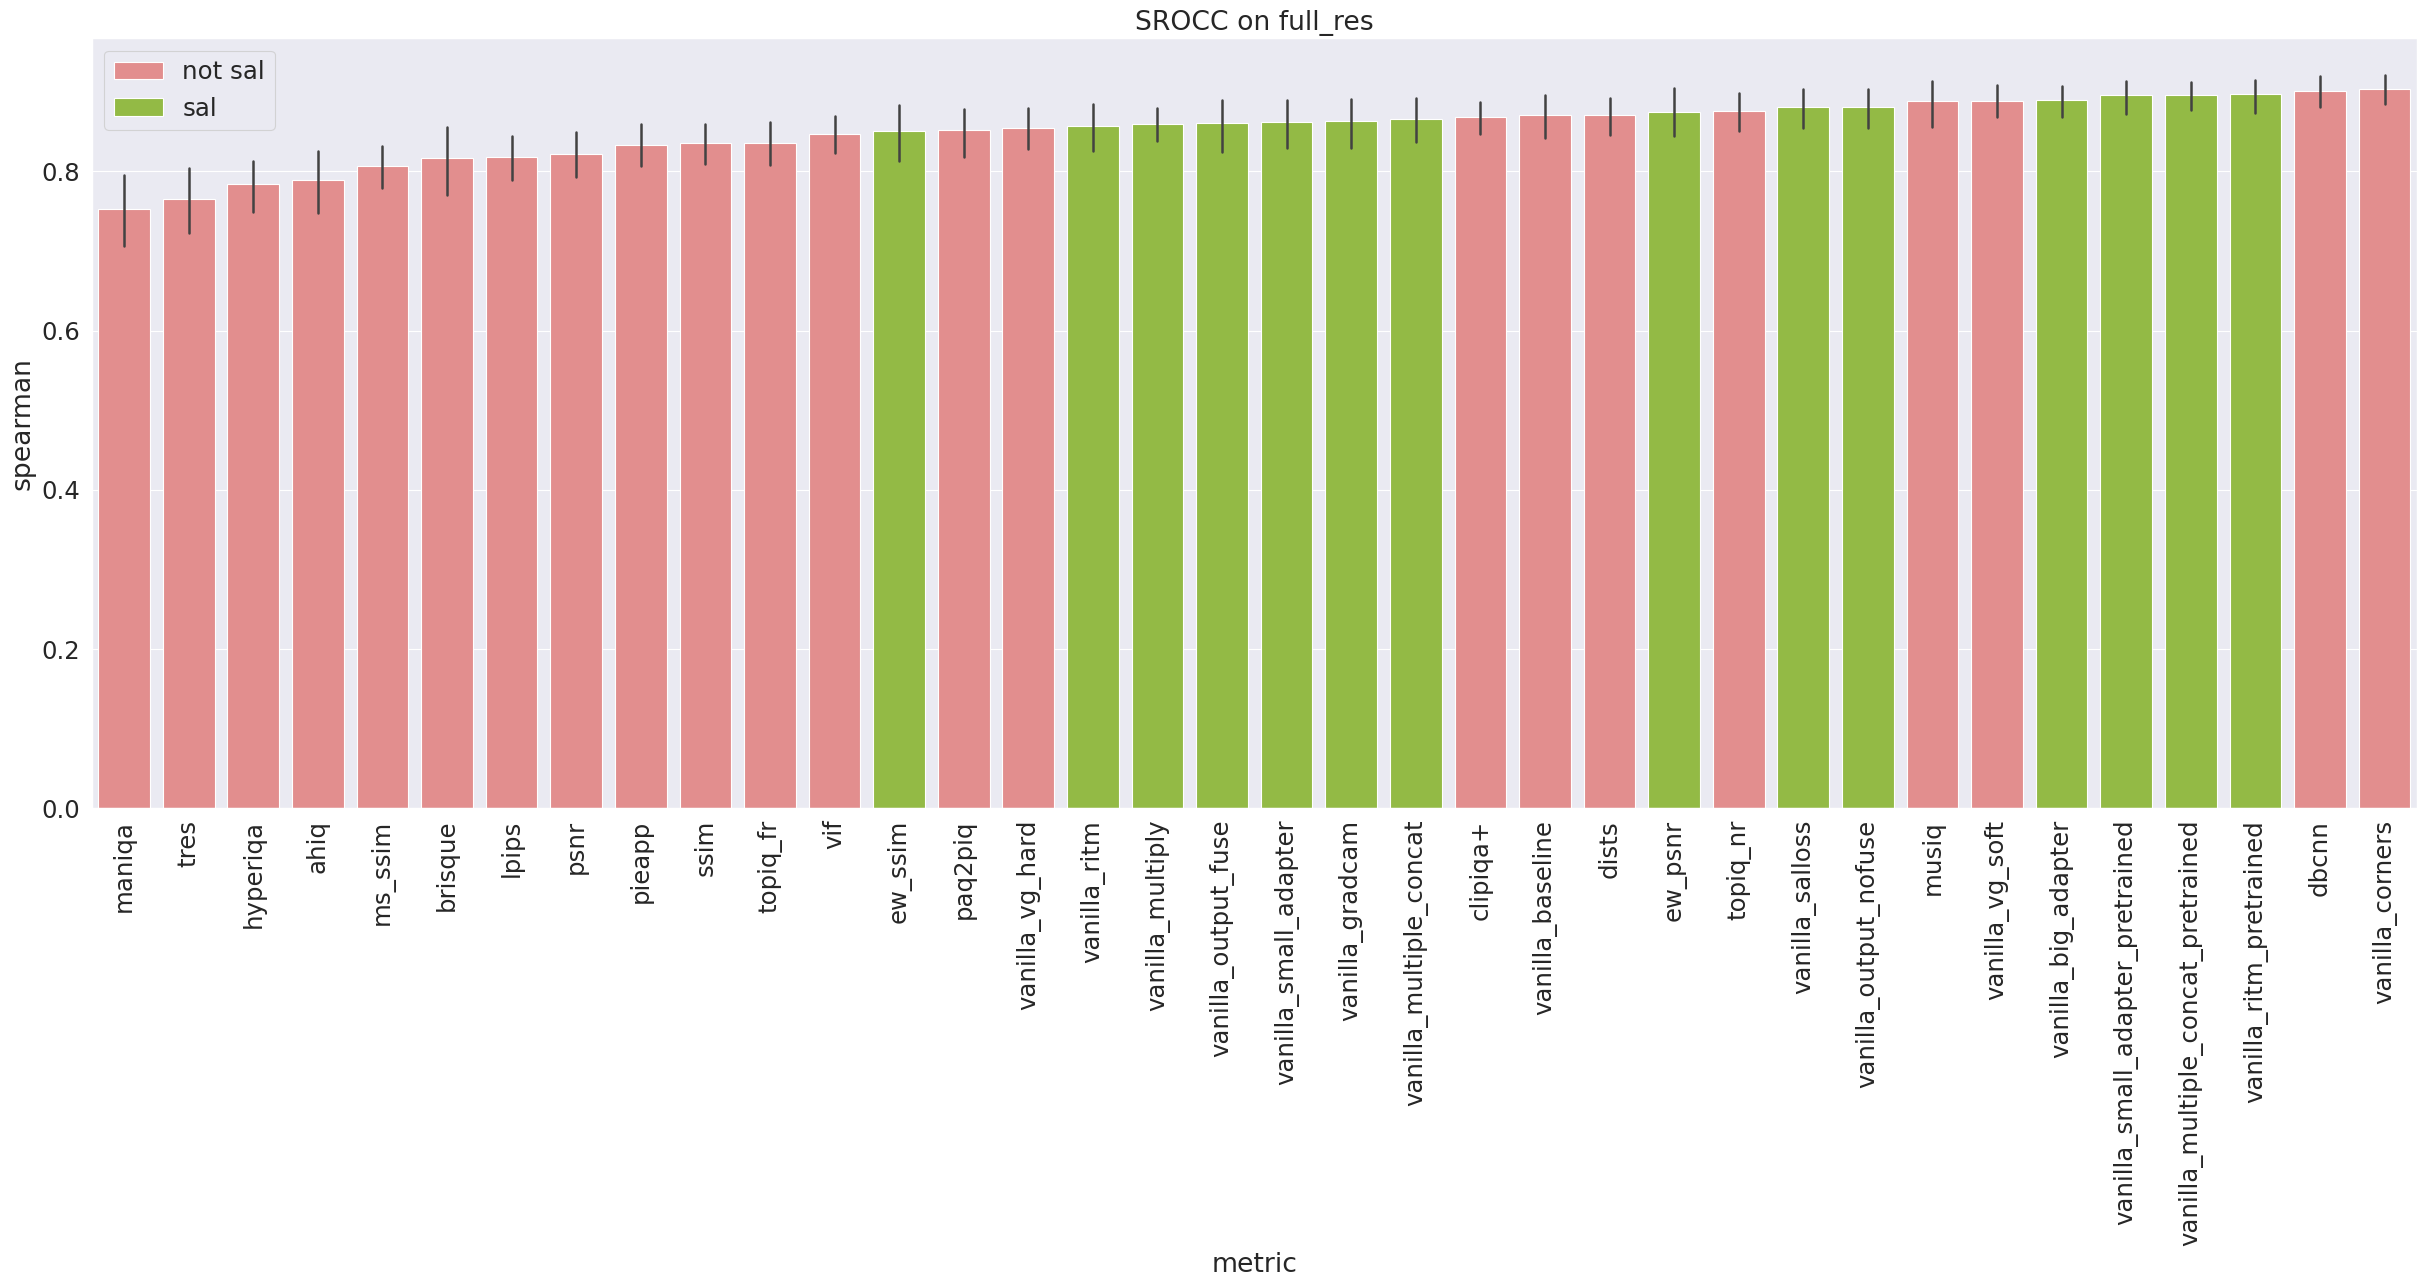

In [68]:
cols = ['lightcoral' if not x.is_sal else 'yellowgreen' for _, x in metainfo_enriched.iterrows()]

sns.set_context("paper", font_scale=2)      
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.title('SROCC on full_res')                                            
sns.barplot(tmp2, ax=ax, x='metric', y='spearman', order=metainfo_enriched.metric, palette=cols)
plt.xticks(rotation=90)
plt.legend([ax.containers[0], ax.containers[-3]], ['not sal', 'sal'])
plt.show()

/tmp/ipykernel_2953613/3104558780.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(tmp2[~tmp2.metric.str.contains('vanilla')], ax=ax, x='metric', y='spearman', order=[x for x in metainfo_enriched.metric if not 'vanilla' in x], palette=cols)


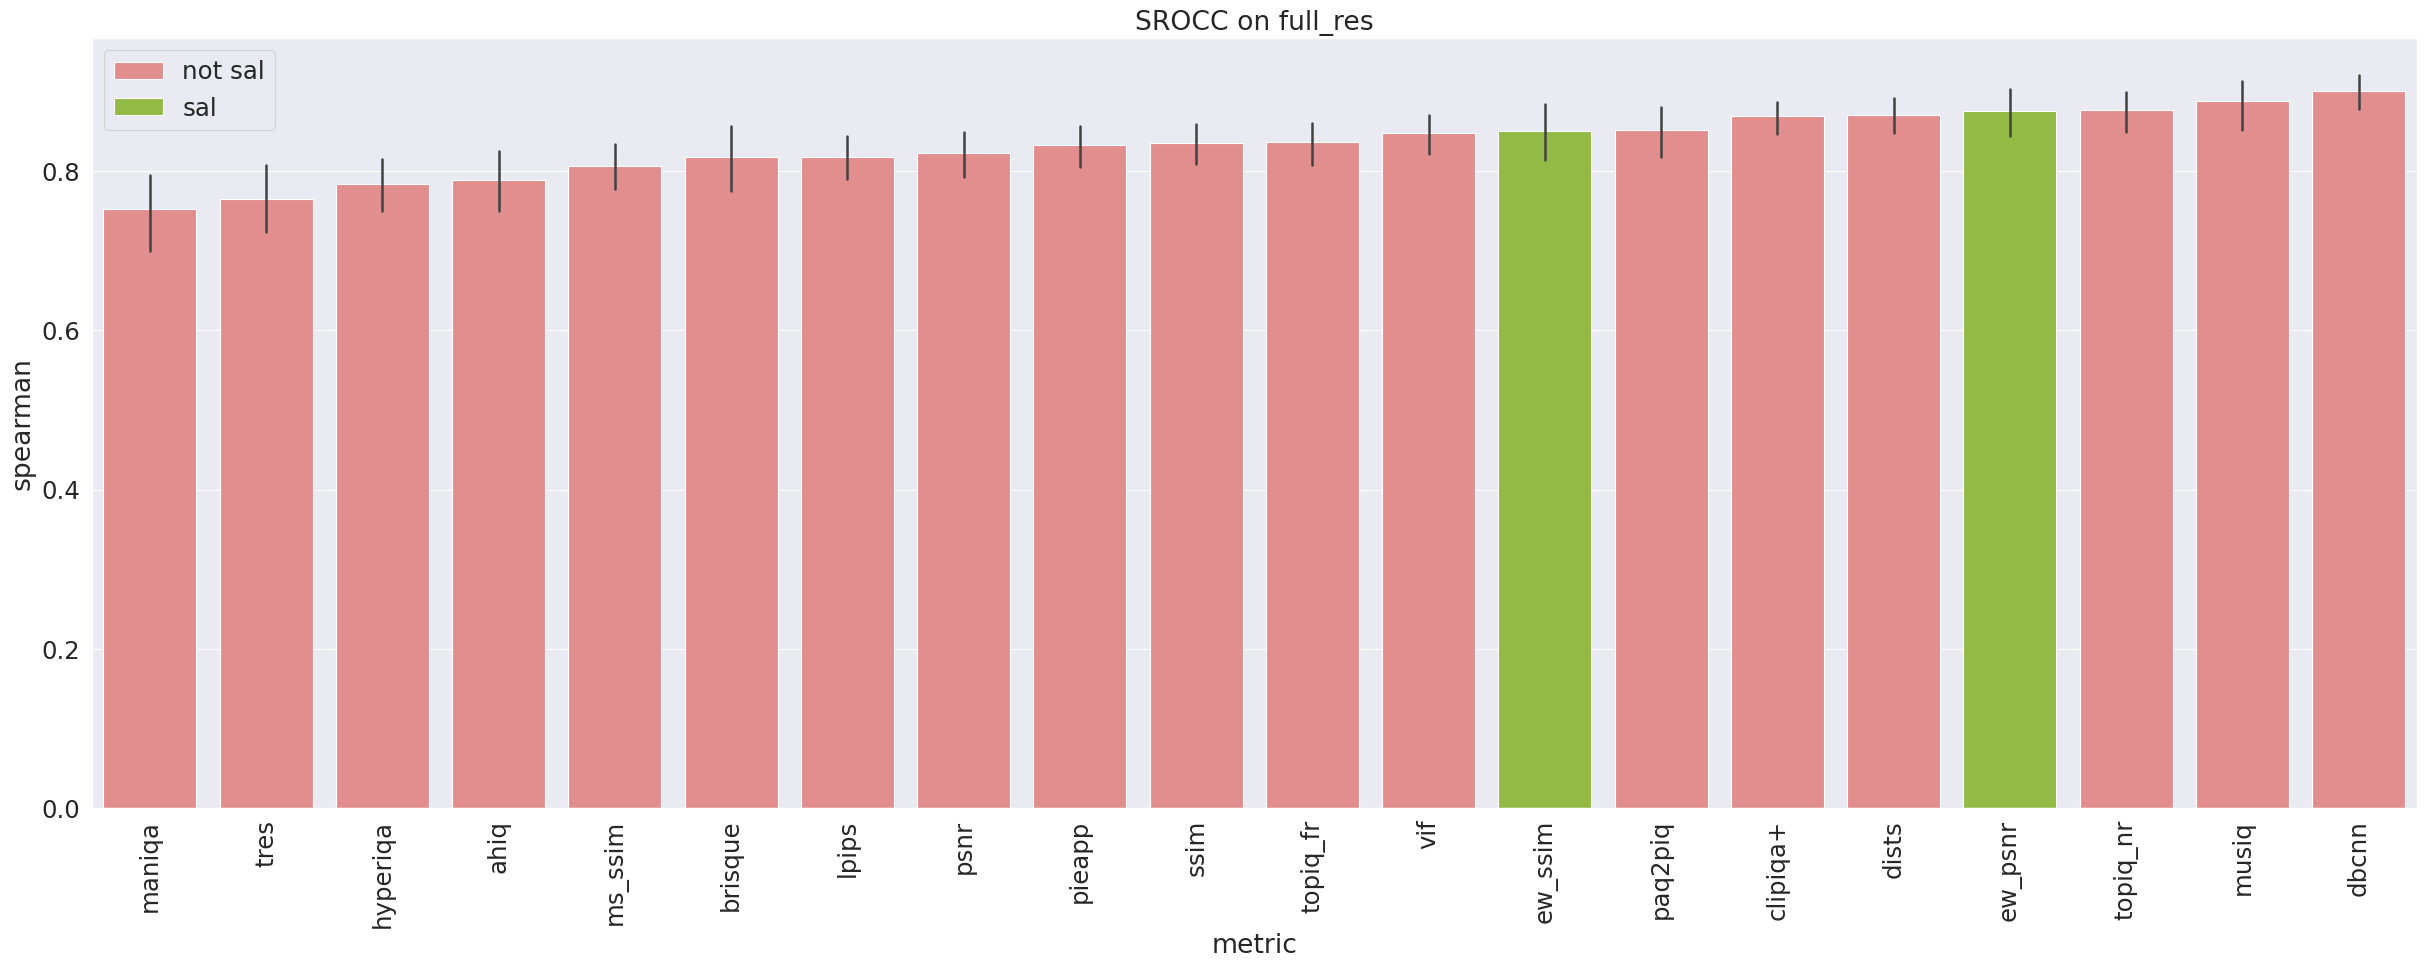

In [70]:
cols = ['lightcoral' if not x.is_sal else 'yellowgreen' for _, x in metainfo_enriched.iterrows() if 'vanilla' not in x.metric]

sns.set_context("paper", font_scale=2)      
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.title('SROCC on full_res')                                            
sns.barplot(tmp2[~tmp2.metric.str.contains('vanilla')], ax=ax, x='metric', y='spearman', order=[x for x in metainfo_enriched.metric if not 'vanilla' in x], palette=cols)
plt.xticks(rotation=90)
plt.legend([ax.containers[0], ax.containers[-4]], ['not sal', 'sal'])
plt.show()